# Project goal:
Predict the delayed status of the flights depart from SFO

# Data sources :
- Flights dataset: United States Department of Transportation
- Weather dataset: Kaggle

In [64]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
import folium.plugins
folium.plugins.MarkerCluster()

import warnings
warnings.simplefilter("ignore")

# 1. Data processing

### 1.1 Read in flights data with selected interested variables

In [13]:
use_var = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_FL_NUM','TAIL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY','CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME','DISTANCE',
        'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'DIVERTED','CANCELLED',
       'CANCELLATION_CODE','NAS_DELAY','SECURITY_DELAY','CARRIER_DELAY',
       'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']

In [14]:
def read_file(year,mon):
    """
    Arg: Year: file year; Mon: file month
    Return: collection of 12 months
    """
    col = pd.read_csv('flights' + '/' + year+'_'+mon+'.csv',usecols=use_var)
    return col

In [15]:
month = []
for mon in range(1,13):
    month.append(str(mon))

In [16]:
col_2013 = pd.concat((read_file('2013',mon) for mon in month),ignore_index=True, sort=False).sort_values(['MONTH','DAY_OF_MONTH'])

In [17]:
col_2014 = pd.concat((read_file('2014',mon) for mon in month),ignore_index=True, sort=False).sort_values(['MONTH','DAY_OF_MONTH'])

In [18]:
col_2015 = pd.concat((read_file('2015',mon) for mon in month),ignore_index=True, sort=False).sort_values(['MONTH','DAY_OF_MONTH'])

In [19]:
col_2013.shape

(6369482, 27)

In [20]:
col_2014.shape

(5819811, 27)

In [21]:
col_2015.shape

(5819079, 27)

In [22]:
col_2013.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
24141,2013,1,1,2,EV,N14570,3815,CLE,ORD,600,559.0,-1.0,624,640.0,16.0,0.0,NaN,0.0,84.0,101.0,65.0,315.0,0.0,0.0,16.0,0.0,0.0
24224,2013,1,1,2,EV,N29906,3817,ORD,CLE,2121,2127.0,6.0,2334,2337.0,3.0,0.0,NaN,0.0,73.0,70.0,50.0,315.0,NaN,NaN,NaN,NaN,NaN
24256,2013,1,1,2,EV,N15574,3818,STL,EWR,1002,1011.0,9.0,1325,1322.0,-3.0,0.0,NaN,0.0,143.0,131.0,97.0,872.0,NaN,NaN,NaN,NaN,NaN
24309,2013,1,1,2,EV,N26549,3821,ALB,CLE,1435,1631.0,116.0,1612,1827.0,135.0,0.0,NaN,0.0,97.0,116.0,88.0,424.0,33.0,0.0,19.0,0.0,83.0
24310,2013,1,1,2,EV,N26549,3821,CLE,ALB,1256,1432.0,96.0,1410,1552.0,102.0,0.0,NaN,0.0,74.0,80.0,54.0,424.0,0.0,0.0,102.0,0.0,0.0


### 1.2 Query sof data and export dataframe to  cvs for further convenience

In [ ]:
sfo2013 = col_2013.query('ORIGIN_AIRPORT=="SFO"')
sfo2013 = col_2014.query('ORIGIN_AIRPORT=="SFO"')
sfo2013 = col_2015.query('ORIGIN_AIRPORT=="SFO"')

In [ ]:
sfo2013.to_csv('sfo2013.csv')
sfo2014.to_csv('sfo2014.csv')
sfo2015.to_csv('sfo2015.csv')

### Variable clarification
- __YEAR__: 2013-2015
- __MONTH__: 1-12(JAN-DEC)
- __DAY_OF_WEEK__: 1-7(MON-SUN)
- __OP_UNIQUE_CARRIER__: Airline
- __ORIGIN__: Departure airport
- __DEST__: Arrival airport
- __CRS_DEP_TIME__: Scheduled departure time (first 2 digits are hour, last 2 digits are minute)
- __CANCELLED__: If the flight is cancelled (YES=1)
- __DEP_DELAY__: Departure delay in minute
- __CARRIER_DELAY__: Delay due to airline operation
- __WEATHER_DELAY__: Delay due to unsatisfactory weather 
- __NAS_DELAY__: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc 
- __SECURITY_DELAY__: Delay due to secruity issue
- __LATE_AIRCRAFT_DELAY__: Delay due to late arrival aircraft

In [65]:
# only import the data with insteresed variables
interest_var = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
              'DEST', 'CRS_DEP_TIME', 'CANCELLED','DEP_DELAY', 'DISTANCE', 'CARRIER_DELAY',
              'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
sfo2013 = pd.read_csv('sfo2013.csv', usecols=interest_var)
sfo2014 = pd.read_csv('sfo2014.csv', usecols=interest_var)
sfo2015 = pd.read_csv('sfo2015.csv', usecols=interest_var)

In [66]:
sfo = pd.concat([sfo2013,sfo2014,sfo2015],sort=False) #concatenate all dataset in one
sfo.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2013,1,1,2,F9,SFO,DEN,615,-10.0,0,967,NaN,NaN,NaN,NaN,NaN
1,2013,1,1,2,F9,SFO,DEN,1855,13.0,0,967,0.0,0.0,6.0,0.0,13.0
2,2013,1,1,2,F9,SFO,DEN,1040,0.0,0,967,NaN,NaN,NaN,NaN,NaN
3,2013,1,1,2,F9,SFO,DEN,1454,-10.0,0,967,NaN,NaN,NaN,NaN,NaN
4,2013,1,1,2,FL,SFO,ATL,2325,43.0,0,2139,28.0,0.0,0.0,0.0,0.0


In [67]:
sfo.shape

(497141, 16)

## 1.2 Drop NA records
### drop criterions:
- Since our goal is to predict the delayed status of a flight, we keep the records with non-NAN 'DEP_DELAY'
- We consider a cancelled flight as a delayed flight

In [68]:
nsfo = sfo.dropna(subset=['DEP_DELAY','CANCELLED'])
nsfo.shape

(487629, 16)

In [69]:
var_info = pd.DataFrame(sfo.dtypes).T.rename(index={0:'dtypes'})
var_info = var_info.append(pd.DataFrame(sfo.notnull().sum()).T.rename(index={0:'# NA before'})) #non-NAN records before drop
var_info = var_info.append(pd.DataFrame(nsfo.notnull().sum()).T.rename(index={0:'# NA after'})) #non-NAN records after drop
var_info = var_info.append(pd.DataFrame(var_info.iloc[1]-var_info.iloc[2]).T.rename(index={0:'dropped'})) #number of records are dropped
var_info

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
dtypes,int64,int64,int64,int64,object,object,object,int64,float64,int64,int64,float64,float64,float64,float64,float64
# NA before,497141,497141,497141,497141,497141,497141,497141,497141,487629,497141,497141,105500,105500,105500,105500,105500
# NA after,487629,487629,487629,487629,487629,487629,487629,487629,487629,487629,487629,105500,105500,105500,105500,105500
dropped,9512,9512,9512,9512,9512,9512,9512,9512,0,9512,9512,0,0,0,0,0


In [70]:
drop_per = (sfo.shape[0]-nsfo.shape[0])/sfo.shape[0]
print('{}% of the original records are dropped'.format(drop_per*100))

1.9133404808696124% of the original records are dropped


In [71]:
# convert 'YEAR','MONTH','DAY_OF_WEEK' to datetime type variable YMD
nsfo.rename(columns={'DAY_OF_MONTH':'DAY'},inplace=True)
nsfo['YMD'] = pd.to_datetime(nsfo[['YEAR','MONTH','DAY']],format='%Y-%m-%d')

In [72]:
"""we want to know at which hour does a flight is
schedule to take off"""
nsfo.CRS_DEP_TIME = nsfo.CRS_DEP_TIME.astype('str')
nsfo['HOUR'] = nsfo.CRS_DEP_TIME.str[:-2] # extract hour
nsfo.loc[nsfo.HOUR == '','HOUR'] = '0' # fill empty hour with 0
nsfo.HOUR

0          6
1         18
2         10
3         14
4         23
5         13
6          7
7          8
8          9
9         21
10        15
11         7
12        14
13         7
14         0
15        18
16        12
17        22
18        14
19        14
20        13
21        10
22         9
23        11
24         6
25         8
26        23
27        12
28        12
29         6
          ..
162148     9
162149     7
162150     6
162151     8
162152     6
162153    22
162154     7
162155     6
162156    17
162157     0
162158    21
162159    12
162160     6
162161    13
162162     7
162163     8
162164    10
162165    12
162166    16
162167    14
162168    21
162169    11
162170     6
162171    12
162172    17
162173    14
162174    20
162175     9
162176     8
162177     9
Name: HOUR, Length: 487629, dtype: object

## 1.3 Add a new variable "HDAYS": number of days to the nearest holiday

In [73]:
sf_13 = nsfo.query('YEAR == 2013')
sf_14 = nsfo.query('YEAR == 2014')
sf_15 = nsfo.query('YEAR == 2015')

#### Define holiday dates

In [74]:
holiday_13 = pd.DataFrame([[1,1,'New Year''s Day'], [1,21,'Martin Luther King Day'],[2,14,'Valentine''s Day'], 
                           [2,18,'Presidents Day'], [3,31,"Easter"],[5,27,"Memorial Day"],[7,4,"Independence Day"], 
                           [9,2,"Labor Day"],[10,14,"Columbus Day"], [10,31,"Halloween"], [11,11,"Veterans'Day"],
                           [11,28,"Thanksgiving"], [12,25,"Christmas Day"],[12,31,"New Year Eve"]])

In [75]:
holiday_14 = pd.DataFrame([[1,1,'New Year''s Day'], [1,20,'Martin Luther King Day'],[2,14,'Valentine''s Day'], 
                           [2,17,'Presidents Day'], [4,20,"Easter"],[5,26,"Memorial Day"], [7,4,"Independence Day"],
                           [9,1,"Labor Day"],[10,13,"Columbus Day"], [10,31,"Halloween"], [11,11,"Veterans'Day"],
                           [11,27,"Thanksgiving"], [12,25,"Christmas Day"],[12,31,"New Year Eve"]])

In [76]:
holiday_15 = pd.DataFrame([[1,1,'New Year''s Day'], [1,19,'Martin Luther King Day'],[2,14,'Valentine''s Day'],
                           [2,16,'Presidents Day'], [4,5,"Easter"],[5,25,"Memorial Day"],[7,4,"Independence Day"],
                           [9,7,"Labor Day"],[10,12,"Columbus Day"], [10,31,"Halloween"], [11,11,"Veterans'Day"],
                           [11,26,"Thanksgiving"], [12,25,"Christmas Day"],[12,31,"New Year Eve"]])

In [77]:
holiday_13.rename(columns={0:'MONTH', 1:'DAY', 2:'HOLIDAY'},inplace=True)
holiday_14.rename(columns={0:'MONTH', 1:'DAY', 2:'HOLIDAY'},inplace=True)
holiday_15.rename(columns={0:'MONTH', 1:'DAY', 2:'HOLIDAY'},inplace=True)

#### Calculate number of days from the nearest holiday for each flight

In [78]:
def get_date_diff(date1_str, date2_str):
    """
    Args:
        date1_str: target date
        date2_str: holiday date
        
    Returns:
        diff.days: difference in days
    """
    date1 = datetime.datetime.strptime(date1_str, '%m-%d')
    date2 = datetime.datetime.strptime(date2_str, '%m-%d')
    diff = abs(date1 - date2)
    return diff.days

In [79]:
def calculate_hdays(sf, holiday):
    """Calculate the number of days to the nearest holiday for a sigle day.
    
    Args:
        sf: The dataframe with flights' dates
        holiday: The dataframe with holidays' dates
        
    Returns:
        sf_new: The dataframe with "HDAYS".
    
    """
    sf_grp = sf.groupby(['MONTH','DAY'])
    dates = list(sf_grp.groups) #a list of key: (MONTH,DAY_OF_MONTH)
    sf.insert(1,'DATE',0)
    sf['DATE'] = sf.MONTH.astype(str)+'-'+sf.DAY.astype(str)
    dates_str = [str(item[0])+'-'+ str(item[1]) for item in dates]
    HDAYS = []
    for item in dates_str:
        cal_hdays = holiday[abs(holiday.MONTH - int(item.split('-')[0]) <=1)] #extract holidays that within +-1 month
        cal_str = cal_hdays.MONTH.astype(str).str.cat(cal_hdays.DAY.astype(str), sep = '-')
        DIS = [get_date_diff(item, d) for d in cal_str]
        HDAYS.append(min(DIS)) #save nearest day
    df = pd.DataFrame([dates_str,HDAYS]).T #transpose indexes to columns 
    df.rename(columns={0:'DATE',1:'HDAYS'},inplace=True)
    sf_new = pd.merge(sf,df,how='outer')
    
    return sf_new

In [80]:
df_13 = calculate_hdays(sf_13, holiday_13)
df_14 = calculate_hdays(sf_14, holiday_14)
df_15 = calculate_hdays(sf_15, holiday_15)

In [81]:
nsfo = pd.concat([df_13,df_14,df_15])
del nsfo['DATE']
nsfo.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,YMD,HOUR,HDAYS
0,2013,1,1,2,F9,SFO,DEN,615,-10.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,6,0
1,2013,1,1,2,F9,SFO,DEN,1855,13.0,0,967,0.0,0.0,6.0,0.0,13.0,2013-01-01,18,0
2,2013,1,1,2,F9,SFO,DEN,1040,0.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,10,0
3,2013,1,1,2,F9,SFO,DEN,1454,-10.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,14,0
4,2013,1,1,2,FL,SFO,ATL,2325,43.0,0,2139,28.0,0.0,0.0,0.0,0.0,2013-01-01,23,0


## 1.4 Deal with weather data

In [82]:
#only keep San Francisco's data
humidity = pd.read_csv('humidity.csv', usecols=['datetime','San Francisco'])
temperature = pd.read_csv('temperature.csv', usecols=['datetime','San Francisco'])
description = pd.read_csv('weather_description.csv', usecols=['datetime','San Francisco'])
wind_speed = pd.read_csv('wind_speed.csv', usecols=['datetime','San Francisco'])

In [83]:
humidity.columns=['datetime','HUMIDITY']
temperature.columns=['datetime','TEMPERATURE']
description.columns=['datetime','DESCRIPTION']
wind_speed.columns=['datetime','WIND_SPEED']

In [84]:
weather = pd.concat([humidity, temperature,description,wind_speed])
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.set_index('datetime')['2013':'2015'].reset_index() #extract data from 2013-2015

In [85]:
# weather['date'] = weather.datetime.apply(lambda x: str(x.date()))
weather['DATE'] = weather['datetime'].apply(lambda x:str(x)[0:10])
del weather['datetime']

In [86]:
weather_full = weather.dropna(how = 'all')
weather_full.head()

,DESCRIPTION,HUMIDITY,TEMPERATURE,WIND_SPEED,DATE
0,NaN,58.0,NaN,NaN,2013-01-01
1,NaN,62.0,NaN,NaN,2013-01-01
2,NaN,70.0,NaN,NaN,2013-01-01
3,NaN,70.0,NaN,NaN,2013-01-01
4,NaN,70.0,NaN,NaN,2013-01-01


In [87]:
weather_mean = weather_full.groupby('DATE').mean().dropna().reset_index()
weather_mean['DATE'] = pd.to_datetime(weather_mean['DATE'])

In [88]:
nsfo = pd.merge(nsfo, weather_mean, left_on='YMD', right_on='DATE',how = 'inner')
nsfo.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,YMD,HOUR,HDAYS,DATE,HUMIDITY,TEMPERATURE,WIND_SPEED
0,2013,1,1,2,F9,SFO,DEN,615,-10.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,6,0,2013-01-01,61.136364,279.84875,1.666667
1,2013,1,1,2,F9,SFO,DEN,1855,13.0,0,967,0.0,0.0,6.0,0.0,13.0,2013-01-01,18,0,2013-01-01,61.136364,279.84875,1.666667
2,2013,1,1,2,F9,SFO,DEN,1040,0.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,10,0,2013-01-01,61.136364,279.84875,1.666667
3,2013,1,1,2,F9,SFO,DEN,1454,-10.0,0,967,NaN,NaN,NaN,NaN,NaN,2013-01-01,14,0,2013-01-01,61.136364,279.84875,1.666667
4,2013,1,1,2,FL,SFO,ATL,2325,43.0,0,2139,28.0,0.0,0.0,0.0,0.0,2013-01-01,23,0,2013-01-01,61.136364,279.84875,1.666667


## 1.5 Define the DELAY of flights as more than 15 mins late

In [89]:
"""define delayed flight as 1
otherwise, define as 0
"""
nsfo.loc[(nsfo["DEP_DELAY"] > 15) & (nsfo['CANCELLED'] == 0), "DELAY_FLAG"] = 1
nsfo.loc[nsfo['DELAY_FLAG']!=1, "DELAY_FLAG"] = 0

In [90]:
sfo_delay = nsfo.query('DELAY_FLAG == 1')

In [91]:
sfo_delay.shape

(103890, 24)

In [92]:
sfo_delay.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,YMD,HOUR,HDAYS,DATE,HUMIDITY,TEMPERATURE,WIND_SPEED,DELAY_FLAG
4,2013,1,1,2,FL,SFO,ATL,2325,43.0,0,2139,28.0,0.0,0.0,0.0,0.0,2013-01-01,23,0,2013-01-01,61.136364,279.84875,1.666667,1.0
8,2013,1,1,2,HA,SFO,HNL,900,372.0,0,2399,389.0,0.0,0.0,0.0,0.0,2013-01-01,9,0,2013-01-01,61.136364,279.84875,1.666667,1.0
13,2013,1,1,2,AA,SFO,DFW,705,17.0,0,1464,NaN,NaN,NaN,NaN,NaN,2013-01-01,7,0,2013-01-01,61.136364,279.84875,1.666667,1.0
17,2013,1,1,2,AA,SFO,JFK,2240,47.0,0,2586,0.0,0.0,0.0,0.0,31.0,2013-01-01,22,0,2013-01-01,61.136364,279.84875,1.666667,1.0
32,2013,1,1,2,AA,SFO,LAX,2000,63.0,0,337,50.0,0.0,0.0,0.0,9.0,2013-01-01,20,0,2013-01-01,61.136364,279.84875,1.666667,1.0


# 2. Data exploration

## 2.1 Flights overview

### 2.1.1 Flights from SFO to different airports

In [93]:
#Data for airports location
airports = pd.read_csv('airports.csv')
airports=airports[["LONGITUDE","LATITUDE","IATA_CODE","STATE"]].dropna()
Air = pd.DataFrame(nsfo.groupby('DEST').size().reset_index(name='AirCount'))
Air=Air.rename(columns={'DEST':'IATA_CODE'})
Air=Air.merge(airports, on='IATA_CODE')

In [94]:
# Add SFO to the airports list
SFO = pd.DataFrame({
    'IATA_CODE': 'SFO',
    'AirCount': [0],
    'LONGITUDE': [-122.3790],
    'LATITUDE': [37.6213],
    'STATE':'CA'
})

Air = pd.concat([Air,SFO],ignore_index=True)
Air.head()

,IATA_CODE,AirCount,LONGITUDE,LATITUDE,STATE
0,ABQ,1196,-106.60919,35.04022,NM
1,ACV,5621,-124.10862,40.97812,CA
2,ANC,589,-149.99619,61.17432,AK
3,ASE,503,-106.86885,39.22316,CO
4,ATL,10374,-84.42694,33.64044,GA


#### A map displaying all airports' locations

In [95]:
map = folium.Map(location=[37.6213, -122.3790], 
                   #tiles='Cartodb Positron',
                   #marker_color='green'
                   zoom_start=4)
marker_cluster = folium.plugins.MarkerCluster().add_to(map)

lonlat = Air[['LONGITUDE','LATITUDE']].dropna()

for each in lonlat.iterrows():
    folium.Marker(
        location = [each[1]['LATITUDE'],each[1]['LONGITUDE']]
    ).add_to(marker_cluster)
    folium.plugins.MarkerCluster()

map

In [96]:
map.save('Airports.html')

#### A map displaying the total flight counts to each state

In [97]:
state_geo = 'us-states.json'
state_data = Air.groupby('STATE')['AirCount'].sum().to_frame().reset_index()

m = folium.Map(location=[37.6213, -122.3790], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['STATE', 'AirCount'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Flights Count'
).add_to(m)

folium.LayerControl().add_to(m)
m

In [98]:
m.save('Flight_counts.html')

In [99]:
# Top five states with the most flights from SFO
state_data.sort_values(by=['AirCount'], ascending=False, na_position='first').head()

,STATE,AirCount
3,CA,140345
29,TX,37945
23,NV,30562
27,OR,29916
9,IL,26753


In [100]:
state_data.AirCount.describe()

count        35.000000
mean      13821.542857
std       24377.873302
min           3.000000
25%        1085.500000
50%        7175.000000
75%       16471.000000
max      140345.000000
Name: AirCount, dtype: float64

### 2.1.2 Flights over DAY_OF_WEEK

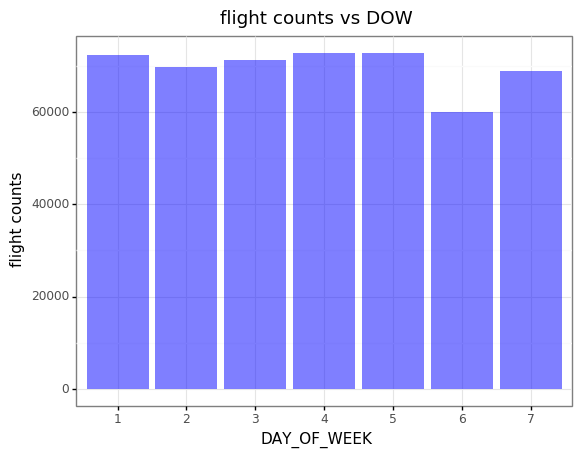

<ggplot: (-9223372036784812505)>

In [101]:
p9.ggplot(nsfo, p9.aes(x='pd.Categorical(DAY_OF_WEEK)')) + p9.geom_col(stat='count',alpha=.5,fill='blue')\
+ p9.labels.ggtitle('flight counts vs DOW') + p9.ylab('flight counts') + p9.xlab('DAY_OF_WEEK')\
+ p9.theme_bw()

- __There are less flights on Saturday, while number of flights on other day of week are roughly the same__

### 2.1.3 Number of flights over MONTH

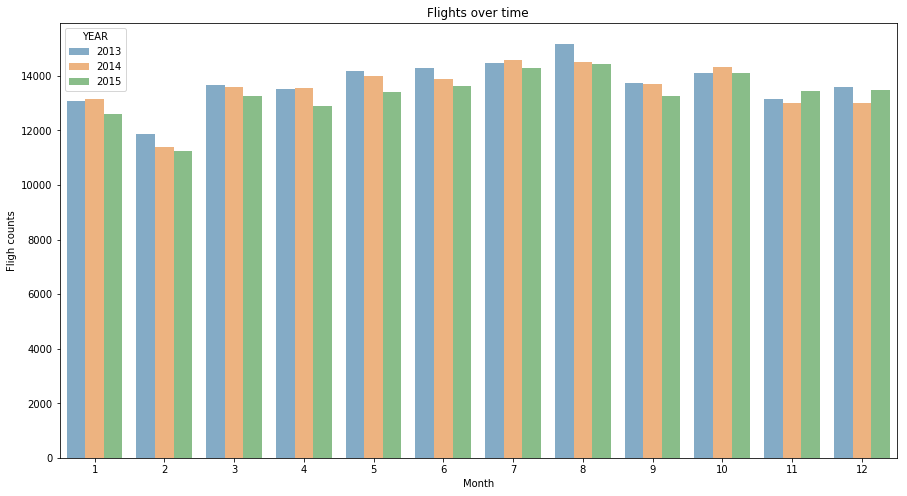

In [102]:
plt.figure(figsize=(15,8))
sns.countplot(x='MONTH',hue='YEAR',alpha=.6,data=nsfo)
plt.xlabel('Month')
plt.ylabel('Fligh counts')
plt.title('Flights over time')
plt.show()

- __Trends of monthly flights for each year are similar, Febuary has the smallest traffic volumn, July/August has the largest traffic volumn__

## 2.2 Explore the reasons for flights' delay

### 2.2.1 Proportion of reasons of delay

In [103]:
reason = nsfo[['YEAR','CARRIER_DELAY','WEATHER_DELAY',
               'NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']]
reason = reason.dropna(subset=['CARRIER_DELAY','WEATHER_DELAY',
               'NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],how='all')

In [104]:
reason.head()

,YEAR,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1,2013,0.0,0.0,6.0,0.0,13.0
4,2013,28.0,0.0,0.0,0.0,0.0
8,2013,389.0,0.0,0.0,0.0,0.0
14,2013,0.0,0.0,18.0,0.0,0.0
17,2013,0.0,0.0,0.0,0.0,31.0


In [105]:
reason.shape

(105500, 6)

In [106]:
# encode reasons with 1(reason presents) and 0(reason absence)
reason['CARRIER_DELAY'] = reason['CARRIER_DELAY'].transform(lambda x: 1 if x!=0 else 0)
reason['WEATHER_DELAY'] = reason['WEATHER_DELAY'].transform(lambda x: 1 if x!=0 else 0)
reason['NAS_DELAY'] = reason['NAS_DELAY'].transform(lambda x: 1 if x!=0 else 0)
reason['SECURITY_DELAY'] = reason['SECURITY_DELAY'].transform(lambda x: 1 if x!=0 else 0)
reason['LATE_AIRCRAFT_DELAY'] = reason['LATE_AIRCRAFT_DELAY'].transform(lambda x: 1 if x!=0 else 0)

In [107]:
reason_grp = reason.groupby('YEAR')

In [108]:
Delay_r = reason_grp.sum()
Delay_r

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
YEAR,,,,,
2013,17233,883,15147,84,22536
2014,20006,931,19138,73,24460
2015,16929,894,14716,73,18101


In [109]:
df = pd.melt(Delay_r.reset_index(),id_vars=Delay_r.index.name)
df.rename(columns={'YEAR':'year','variable':'category','value':'counts'},inplace=True)
df

,year,category,counts
0,2013,CARRIER_DELAY,17233
1,2014,CARRIER_DELAY,20006
2,2015,CARRIER_DELAY,16929
3,2013,WEATHER_DELAY,883
4,2014,WEATHER_DELAY,931
5,2015,WEATHER_DELAY,894
6,2013,NAS_DELAY,15147
7,2014,NAS_DELAY,19138
8,2015,NAS_DELAY,14716
9,2013,SECURITY_DELAY,84


In [110]:
grp = df.groupby('year')
proportion = grp.apply(lambda x: x['counts'] /sum(x['counts']))*100 #calculate proportion
proportion = proportion.to_frame().reset_index().rename(columns={'counts':'proportion'})

In [111]:
proportion = proportion.sort_values(by='level_1').reset_index()
proportion = proportion['proportion']

In [112]:
df = pd.concat([df,proportion],axis = 1,ignore_index=False) #concatenate proportion to df

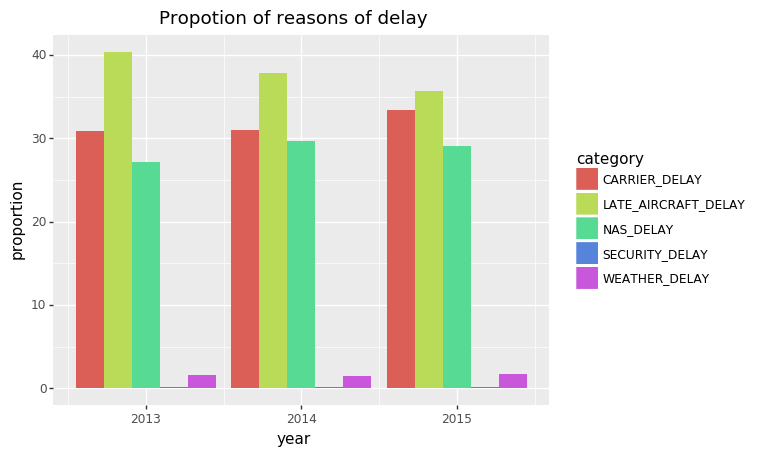

<ggplot: (-9223372036781460129)>

In [113]:
ccolor = '#555555'

(p9.ggplot(df, p9.aes(x='year', y='proportion',fill='category'))
 + p9.geom_bar(stat='identity', position='dodge', show_legend=True)
 + p9.ggtitle('Propotion of reasons of delay')
)

From the figure, we can see that the most common reasons for the flight delay are __LATE_AIRCRAFT_DELAY, CARRIER_DELAY and NAS_DELAY__. Referring to variable clarification, non-extreme weather conditions and air traffic volumn are the reasons of __NAS_DELAY__. Therefore, although __WEATHER_DELAY__ has very low proportion in the chart, we considered weather condition as a significant factor. Therefore, in the following steps, we explored how carriers, the total number of flights in a day, and weather condition affect the flights' delay status.

### 2.2.2 Delay rate with DAY_OF_WEEK

In [114]:
def groups_stat(delay_groups, groups):
    """Calculate descriptive statistics
    Arg: 
    delay_groups: group from delay dataset
    groups: group from full dataset
    
    Return: A statistics table including max, min, mean, median delay and delay rate from delay group
                                         number of total flights from full group
    """
    table = pd.DataFrame(index=delay_groups.groups.keys(), 
                         columns=['MAX_DEL','MIN_DEL','MEAN_DEL','MEDIAN_DEL','DELRT','TOT_COUNT'])
    table['MAX_DEL'] = delay_groups['DEP_DELAY'].apply(max).tolist()
    table['MIN_DEL'] = delay_groups['DEP_DELAY'].apply(min).tolist()
    table['MEAN_DEL'] = delay_groups['DEP_DELAY'].apply(np.mean).tolist()
    table['MEDIAN_DEL'] = delay_groups['DEP_DELAY'].apply(np.median).tolist()
    table['DELRT'] = (delay_groups.apply(len) / groups.apply(len)).tolist()
    table['TOT_COUNT'] = groups.apply(len).tolist()
    return table

In [115]:
#day of week statistics
dow_gby_d = sfo_delay[['YEAR','DAY_OF_WEEK','DEP_DELAY']].groupby(['YEAR','DAY_OF_WEEK'])
dow_gby = nsfo[['YEAR','DAY_OF_WEEK','DEP_DELAY']].groupby(['YEAR','DAY_OF_WEEK'])
dow_stat = groups_stat(dow_gby_d,dow_gby)
dow_stat.reset_index(inplace = True)
dow_stat.rename(columns={'level_0':'YEAR','level_1':'DAY_OF_WEEK'},inplace=True)
dow_stat

,YEAR,DAY_OF_WEEK,MAX_DEL,MIN_DEL,MEAN_DEL,MEDIAN_DEL,DELRT,TOT_COUNT
0,2013,1,1366.0,16.0,64.965812,48.0,0.235374,24357
1,2013,2,1174.0,16.0,64.138391,44.0,0.194200,23553
2,2013,3,609.0,16.0,60.684614,44.0,0.196348,23932
3,2013,4,550.0,16.0,61.608916,45.0,0.218346,24452
4,2013,5,1055.0,16.0,65.034667,46.0,0.220250,24622
5,2013,6,669.0,16.0,59.531401,40.0,0.181349,20546
6,2013,7,933.0,16.0,65.376581,46.0,0.223192,23379
7,2014,1,675.0,16.0,61.389736,45.0,0.243755,24221
8,2014,2,1302.0,16.0,60.968267,42.0,0.211979,23191
9,2014,3,1638.0,16.0,60.764111,43.0,0.241035,23814


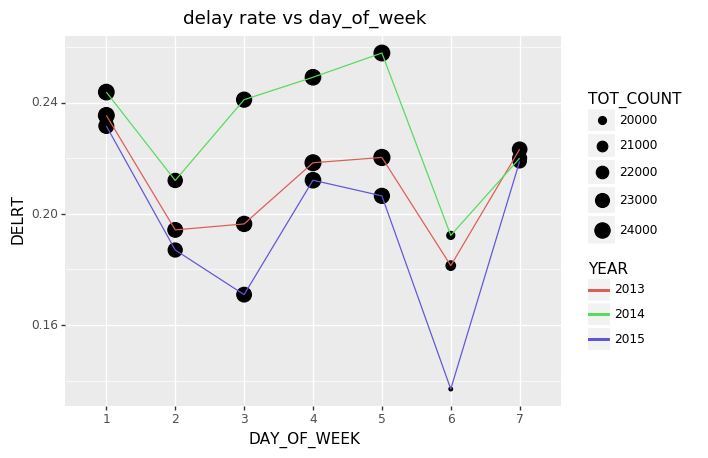

<ggplot: (-9223372036798351388)>

In [116]:
p9.ggplot(dow_stat,p9.aes('pd.Categorical(DAY_OF_WEEK)','DELRT',group='YEAR'))+p9.geom_point(p9.aes(size='TOT_COUNT'))\
+ p9.geom_line(p9.aes(color = 'pd.Categorical(YEAR)'))\
+ p9.labs(x='DAY_OF_WEEK', color = 'YEAR', title = 'delay rate vs day_of_week')

1. __2013 and 2014 have same peaks and trough, while 2015's are slightly differnt__
2. __Apparently, higher day of week air traffic volumn has relatively higher delay rate__
3. __Therefore, we will explore further relation between total flights and day of week__

### 2.2.3 Delay rate with total flights

In [117]:
# #daily stat
day_gby_d = sfo_delay[['YEAR','DATE','DEP_DELAY']].groupby(['YEAR','DATE'])
day_gby = nsfo[['YEAR','DATE','DEP_DELAY']].groupby(['YEAR','DATE'])
day_stat = groups_stat(day_gby_d,day_gby)
day_stat.reset_index(inplace = True)
day_stat.rename(columns={'level_0':'YEAR','level_1':'DATE'},inplace=True)
day_stat

,YEAR,DATE,MAX_DEL,MIN_DEL,MEAN_DEL,MEDIAN_DEL,DELRT,TOT_COUNT
0,2013,2013-01-01,372.0,17.0,54.500000,31.0,0.103371,445
1,2013,2013-01-02,363.0,16.0,45.582090,31.0,0.137577,487
2,2013,2013-01-03,128.0,16.0,46.000000,33.0,0.071895,459
3,2013,2013-01-04,205.0,16.0,58.468085,34.0,0.101732,462
4,2013,2013-01-05,296.0,16.0,62.866667,39.0,0.236220,381
5,2013,2013-01-06,180.0,16.0,55.696970,39.5,0.150342,439
6,2013,2013-01-07,233.0,16.0,46.875000,32.0,0.109840,437
7,2013,2013-01-08,245.0,16.0,49.257143,28.0,0.087282,401
8,2013,2013-01-09,264.0,16.0,57.366667,46.0,0.291262,412
9,2013,2013-01-10,130.0,17.0,39.647059,29.0,0.113839,448


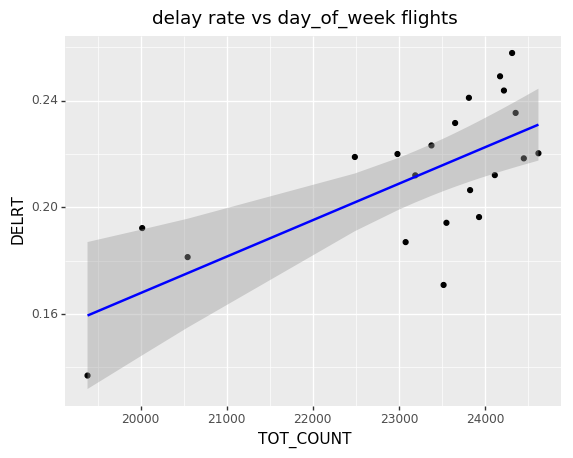

<ggplot: (60473934)>

In [118]:
# counts vs delay rate
p9.ggplot(dow_stat, p9.aes('TOT_COUNT', 'DELRT')) + p9.geom_point()\
+ p9.stat_smooth(method='lm', color='blue')\
+ p9.ggtitle('delay rate vs day_of_week flights')

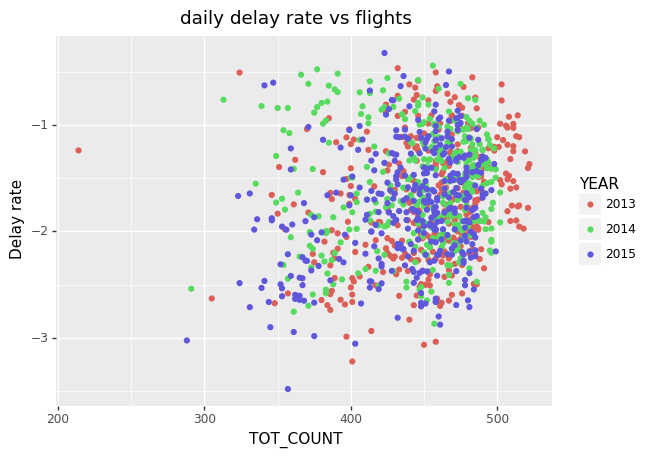

<ggplot: (-9223372036780833932)>

In [119]:
# counts vs delay rate
p9.ggplot(day_stat, p9.aes('TOT_COUNT', 'np.log(DELRT)')) + p9.geom_point(p9.aes(color='pd.Categorical(YEAR)'))\
+ p9.labs(y='Delay rate', color = 'YEAR', title='daily delay rate vs flights')

- __Regarding the scatter plots above, day-of-week delay rate and flight counts have strong positive correlation. However, the population is very small so that it is not very persuasive__.
- __It's mroe clear on daily basis that delay rate does not  flights change. Therefore, day_of_week flight count is more significant to the change of delay rate.__

### 2.2.4 Delay rate with MONTH

In [120]:
#monthly statistics
mon_gby_d = sfo_delay[['YEAR','MONTH','DEP_DELAY']].groupby(['YEAR','MONTH'])
mon_gby = nsfo[['YEAR','MONTH','DEP_DELAY']].groupby(['YEAR','MONTH'])
mon_stat = groups_stat(mon_gby_d,mon_gby).reset_index()
mon_stat.rename(columns={'level_0':'YEAR','level_1':'MONTH'},inplace=True)
mon_stat

,YEAR,MONTH,MAX_DEL,MIN_DEL,MEAN_DEL,MEDIAN_DEL,DELRT,TOT_COUNT
0,2013,1,422.0,16.0,53.098398,36.0,0.133834,13061
1,2013,2,734.0,16.0,57.194575,40.0,0.143050,11856
2,2013,3,594.0,16.0,62.628326,45.0,0.187006,13668
3,2013,4,1174.0,16.0,60.063887,43.0,0.219694,13537
4,2013,5,669.0,16.0,62.586244,46.0,0.198080,14166
5,2013,6,1366.0,16.0,72.029389,52.0,0.273694,14297
6,2013,7,639.0,16.0,73.548010,54.0,0.307219,14475
7,2013,8,1055.0,16.0,63.171633,48.0,0.293967,15182
8,2013,9,984.0,16.0,63.534179,47.0,0.206610,13736
9,2013,10,608.0,16.0,61.321772,43.0,0.169464,14121


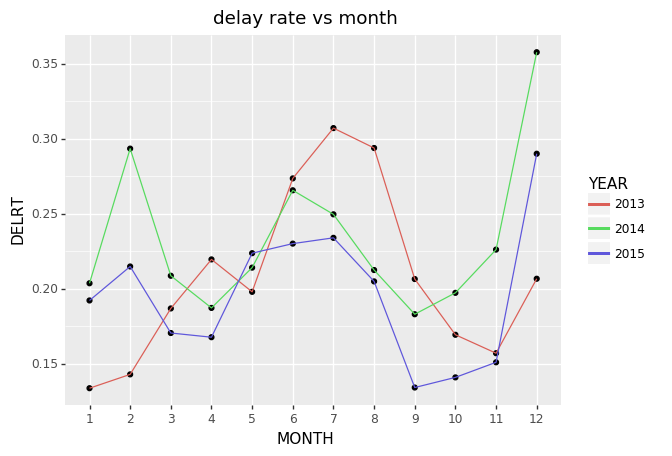

<ggplot: (56419048)>

In [121]:
p9.ggplot(mon_stat,p9.aes(x = 'pd.Categorical(MONTH)', y='DELRT',group='YEAR')) + p9.geom_point()\
+ p9.geom_line(p9.aes(color='pd.Categorical(YEAR)'))\
+ p9.labs(x='MONTH', color = 'YEAR')\
+ p9.ggtitle('delay rate vs month')

- __Delay rates over months have different peaks and troughs in different year. Therefore, year and month both affect delay rate.__

### 2.2.5 Delay rate with AIRLINE

In [122]:
#Airlines statistics
al_gby_d = sfo_delay[['OP_UNIQUE_CARRIER','DEP_DELAY']].groupby('OP_UNIQUE_CARRIER')
al_gby = nsfo[['OP_UNIQUE_CARRIER','DEP_DELAY']].groupby('OP_UNIQUE_CARRIER')
al_stat = groups_stat(al_gby_d,al_gby).reset_index()
al_stat.rename(columns={'index':'airline'},inplace=True)
al_stat

,airline,MAX_DEL,MIN_DEL,MEAN_DEL,MEDIAN_DEL,DELRT,TOT_COUNT
0,AA,1772.0,16.0,72.824040,44.0,0.185033,34891
1,AS,754.0,16.0,64.203500,47.0,0.164966,14894
2,B6,603.0,16.0,63.325125,44.0,0.222840,13485
3,DL,797.0,16.0,61.498251,38.0,0.122583,27981
4,F9,782.0,16.0,68.225929,45.0,0.259085,5091
5,FL,376.0,16.0,52.683824,37.0,0.239859,1134
6,HA,961.0,16.0,105.603175,39.5,0.084734,1487
7,OO,688.0,16.0,63.116136,48.0,0.241426,128325
8,UA,1088.0,16.0,59.546010,40.0,0.223528,150858
9,US,485.0,16.0,55.152667,38.0,0.112427,13342


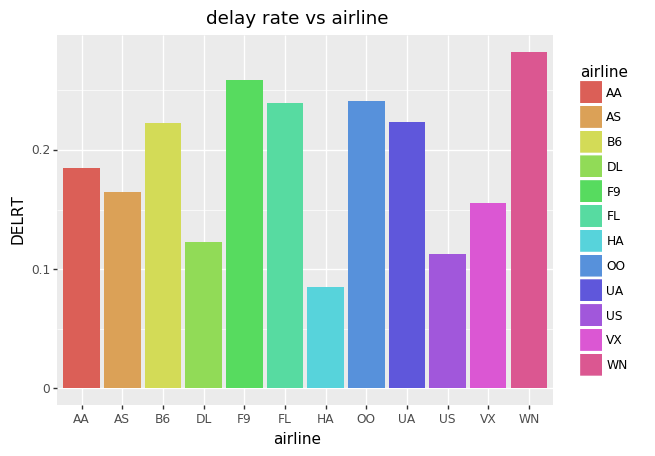

<ggplot: (73945678)>

In [123]:
p9.ggplot(al_stat,p9.aes('airline','DELRT',fill='airline'))+p9.geom_col()\
+ p9.ggtitle('delay rate vs airline')

- __South-West Airline has the highest delay rate, while Hawaiian Airline has the significantly lowest delay rate.__

### 2.2.6 Delay rate with HOUR

In [124]:
#hourly statistics
hour_gby_d = sfo_delay[['YEAR','HOUR','DEP_DELAY']].groupby(['YEAR','HOUR'])
hour_gby = nsfo[['YEAR','HOUR','DEP_DELAY']].groupby(['YEAR','HOUR'])
hour_stat = groups_stat(hour_gby_d,hour_gby)
hour_stat.reset_index(inplace = True)
hour_stat.rename(columns={'level_0':'YEAR','level_1':'HOUR'},inplace=True)
hour_stat

,YEAR,HOUR,MAX_DEL,MIN_DEL,MEAN_DEL,MEDIAN_DEL,DELRT,TOT_COUNT
0,2013,0,210.0,16.0,50.380952,36.0,0.158159,1195
1,2013,1,54.0,54.0,54.000000,54.0,0.500000,2
2,2013,10,587.0,16.0,62.743330,44.0,0.223387,13255
3,2013,11,1174.0,16.0,68.543651,49.0,0.268593,8444
4,2013,12,1055.0,16.0,67.356662,51.0,0.278799,10660
5,2013,13,564.0,16.0,62.720958,47.0,0.299864,10995
6,2013,14,933.0,16.0,62.460492,45.0,0.294800,9230
7,2013,15,427.0,16.0,62.069090,46.0,0.277262,10023
8,2013,16,518.0,16.0,62.414977,44.0,0.251102,10211
9,2013,17,375.0,16.0,59.775035,44.0,0.231661,6121


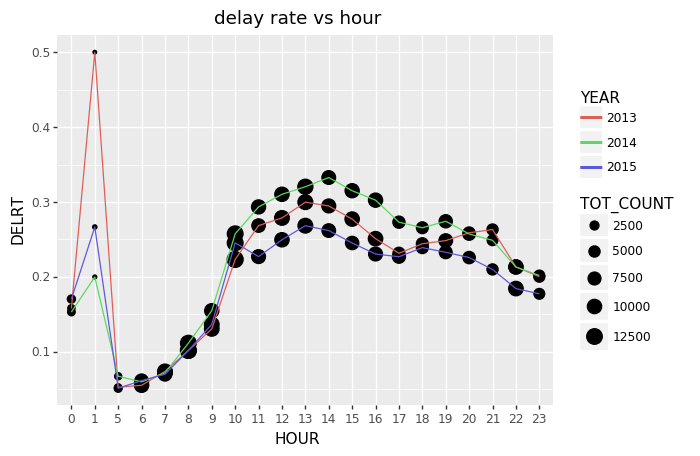

<ggplot: (65081976)>

In [125]:
p9.ggplot(hour_stat,p9.aes(x = 'pd.Categorical(HOUR.astype(int))', y='DELRT',group='YEAR'))\
+ p9.geom_point(p9.aes(size = 'TOT_COUNT'))\
+ p9.geom_line(p9.aes(color='pd.Categorical(YEAR)'))\
+ p9.labs(color = 'YEAR',x='HOUR')\
+ p9.ggtitle('delay rate vs hour')

1. Since the number flights at 1  are extremely small(less than 100), the delay rate at 1  is not informative
2. Delay rate increases gradually startring from 5 a.m., then it drops gradually after 13 and 14
3. There is no obvious association between hourly flight count and hourly delay rate

### 2.2.7 Delay with HDAYS

#### DEP_DELAY with HDAYS

In [126]:
H_grp = sfo_delay[(sfo_delay['DEP_DELAY']>15) & (sfo_delay['CANCELLED']==0)].groupby(['YEAR','HDAYS'])

In [127]:
H_delay = H_grp['DEP_DELAY'].mean().reset_index()
H_delay.head()

,YEAR,HDAYS,DEP_DELAY
0,2013,0,59.669710
1,2013,1,59.150985
2,2013,2,60.508219
3,2013,3,62.032577
4,2013,4,65.651550


In [128]:
H_delay['YEAR'] = H_delay.YEAR.astype('category')

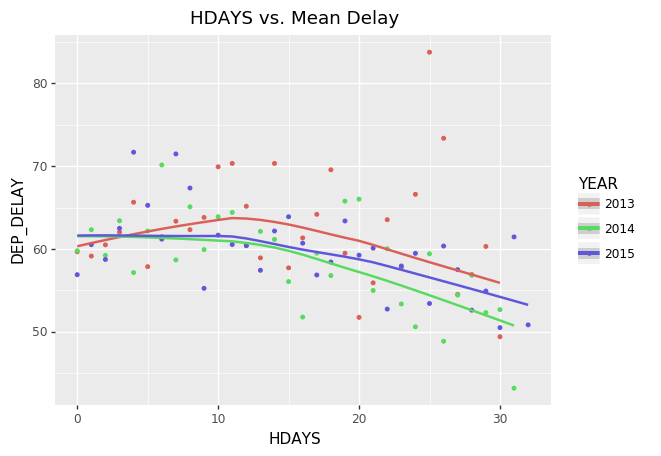

<ggplot: (-9223372036798361214)>

In [129]:
(p9.ggplot(H_delay, p9.aes(x='HDAYS', y='DEP_DELAY',color='YEAR'))
 #+ p9.facet_wrap('YEAR') 
 + p9.geoms.geom_point(size=1)
 + p9.stat_smooth()
 + p9.ggtitle('HDAYS vs. Mean Delay')
)

- __From the plot, the line of 2013 is not always decreasing, which might be caused by other factors like extreme weather. The lines of 2014 and 2015 indicate that the delay of flights is highly correlated with the number of days from the nearest holiday, which means the closer the day is to holiday, the longer delay time the flight is.__

### Delay counts with HDAYS

In [130]:
H_grp = nsfo.groupby(['YEAR','HDAYS'])

In [131]:
d_count = H_grp.DELAY_FLAG.sum().reset_index()
d_count.rename(columns={"DELAY_FLAG":"COUNT"},inplace=True)
d_count.head()

,YEAR,HDAYS,COUNT
0,2013,0,1205.0
1,2013,1,1828.0
2,2013,2,1460.0
3,2013,3,2026.0
4,2013,4,2161.0


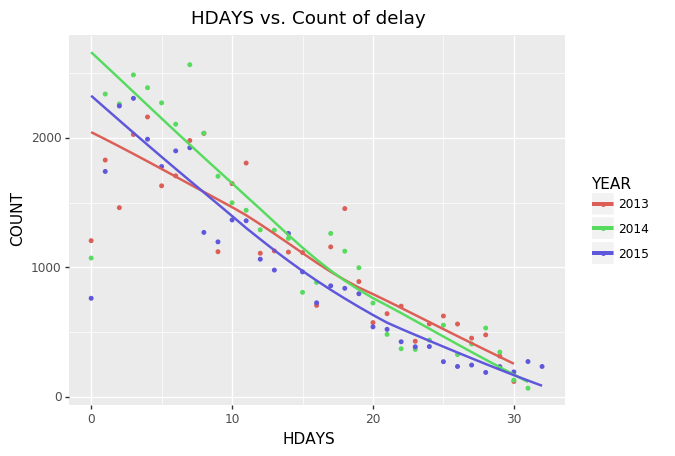

<ggplot: (78567856)>

In [132]:
(p9.ggplot(d_count, p9.aes(x='HDAYS', y='COUNT',color= 'factor(YEAR)'))
 + p9.geoms.geom_point(size=1)
 + p9.stat_smooth(se=False)
 + p9.labs(color = 'YEAR', title = 'HDAYS vs. Count of delay')
)

- __The counts of delay decrease as the day gets farther from a holiday, which indicates a high negative correlation between HDAYS and delay.__

### Delay rate with HDAYS

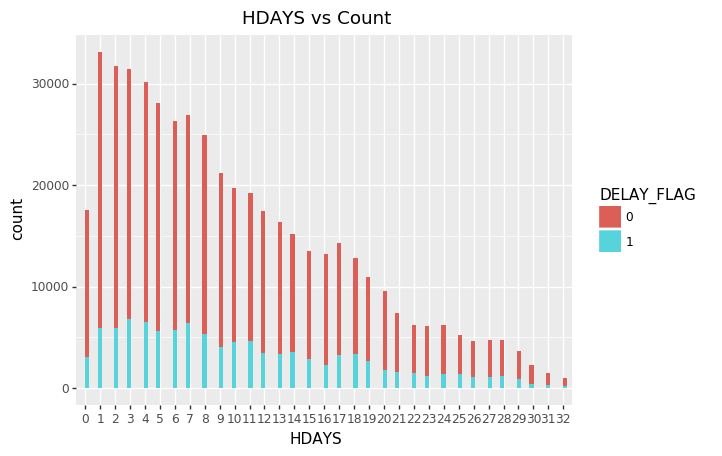

<ggplot: (74055621)>

In [133]:
(p9.ggplot(nsfo[['HDAYS','DELAY_FLAG']].dropna(axis=0)) 
 + p9.aes(x = 'HDAYS',fill = 'factor(DELAY_FLAG)') 
 + p9.geom_histogram()\
 + p9.labs(fill='DELAY_FLAG',title = 'HDAYS vs Count')
)

- __As HDAYS increases, number of flights decrease, which makes sense because more people tend to go traveling during holidays.__

### 2.2.8 Delay with WEATHER

In [134]:
weather = weather.dropna(subset=['DESCRIPTION'])

In [135]:
weather.head()

,DESCRIPTION,HUMIDITY,TEMPERATURE,WIND_SPEED,DATE
52560,few clouds,NaN,NaN,NaN,2013-01-01
52561,few clouds,NaN,NaN,NaN,2013-01-01
52562,few clouds,NaN,NaN,NaN,2013-01-01
52563,sky is clear,NaN,NaN,NaN,2013-01-01
52564,sky is clear,NaN,NaN,NaN,2013-01-01


In [136]:
weather.DESCRIPTION.unique()

array(['few clouds', 'sky is clear', 'scattered clouds', 'broken clouds',
       'moderate rain', 'light rain', 'heavy intensity rain', 'mist',
       'haze', 'heavy snow', 'proximity shower rain', 'overcast clouds',
       'fog', 'drizzle', 'light intensity drizzle',
       'thunderstorm with rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'thunderstorm',
       'thunderstorm with heavy rain', 'heavy intensity drizzle',
       'very heavy rain', 'proximity thunderstorm with rain',
       'light intensity shower rain', 'smoke', 'shower rain', 'squalls'],
      dtype=object)

In [137]:
weather = weather.dropna(subset=['DESCRIPTION'])

In [138]:
# Check if we have weather data for every day
weather.DATE.unique().shape[0] == 365*3

True

In [139]:
weather.insert(0,'WEATHER',0)

In [140]:
"""rank weather conditions into 3 levels, 1-3 corresponding to normal, bad, and terrible"""

normal = ('few clouds', "sky is clear", 'overcast clouds', 'scattered clouds', 'broken clouds', 'mist', 'haze','fog','smoke') 
bad = ('squalls', 'moderate rain', 'light rain','drizzle','light intensity drizzle','light intensity shower rain')
terrible = ('heavy intensity rain','heavy snow','proximity shower rain','thunderstorm with rain',
       'proximity thunderstorm', 'thunderstorm with light rain',
       'thunderstorm', 'thunderstorm with heavy rain','heavy intensity drizzle', 'very heavy rain',
       'proximity thunderstorm with rain','shower rain')

In [141]:
def func(condition):
    """Classify the weather conditions into categorial values.
    
    Args:
        condition: The string description of weather.
        
    Returns:
        x: The value for the specific condition.
    
    """
    if condition in normal:
        x = 1
    elif condition in bad:
        x = 2
    else:
        x = 3
    return x

In [142]:
weather.WEATHER = weather.DESCRIPTION.apply(func)
# weather.head()

In [143]:
weather = weather.groupby('DATE')['WEATHER'].max().to_frame().reset_index()
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather.head()

,DATE,WEATHER
0,2013-01-01,1
1,2013-01-02,3
2,2013-01-03,1
3,2013-01-04,3
4,2013-01-05,1


In [144]:
full_df = pd.merge(weather,nsfo, how = 'inner')
del full_df['YMD']

In [145]:
full_df.shape

(487629, 24)

### Delay counts with WEATHER

In [163]:
d_weather = full_df.groupby(['YEAR','WEATHER'])['DELAY_FLAG'].sum()
d_weather = d_weather.to_frame().reset_index().rename(columns={'DELAY_FLAG':'COUNT'})
d_weather.WEATHER = d_weather.WEATHER.map({1:'normal',2:'bad',3:'terrible'})
d_weather

,YEAR,WEATHER,COUNT
0,2013,normal,18663.0
1,2013,bad,9588.0
2,2013,terrible,6461.0
3,2014,normal,19242.0
4,2014,bad,13636.0
5,2014,terrible,4877.0
6,2015,normal,12780.0
7,2015,bad,12267.0
8,2015,terrible,6376.0


In [164]:
d_weather.YEAR = pd.Categorical(d_weather.YEAR)

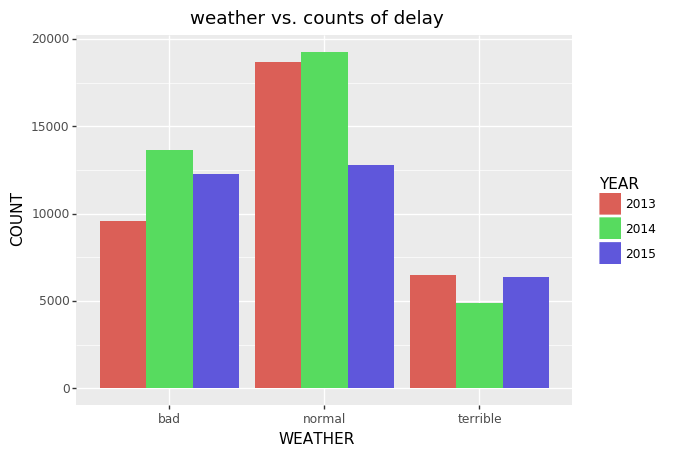

<ggplot: (73945664)>

In [165]:
(p9.ggplot(d_weather, p9.aes(x='WEATHER', y='COUNT',fill= 'YEAR'))
 + p9.geoms.geom_bar(stat='identity', position='dodge', show_legend=True)
 + p9.ggtitle('weather vs. counts of delay')
)

- __The worse the weather is, the fewer flights depart from SFO.__

### Delay rate with WEATHER

In [167]:
d_weather_grp = full_df.groupby(['YEAR','WEATHER'])
d_ratio = (d_weather_grp['DELAY_FLAG'].sum()/d_weather_grp['DELAY_FLAG'].count()).reset_index()
d_ratio.rename(columns={"DELAY_FLAG":"RATIO"},inplace=True)
d_ratio.WEATHER = d_ratio.WEATHER.map({1:'normal',2:'bad',3:'terrible'})
d_ratio

,YEAR,WEATHER,RATIO
0,2013,normal,0.195660
1,2013,bad,0.232324
2,2013,terrible,0.229227
3,2014,normal,0.197346
4,2014,bad,0.271185
5,2014,terrible,0.326592
6,2015,normal,0.175016
7,2015,bad,0.221822
8,2015,terrible,0.200851


In [168]:
d_ratio.YEAR = pd.Categorical(d_weather.YEAR)

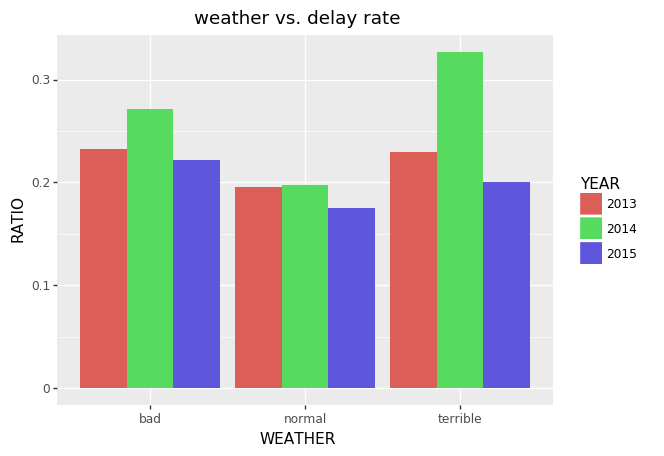

<ggplot: (-9223372036784874941)>

In [169]:
(p9.ggplot(d_ratio, p9.aes(x='WEATHER', y='RATIO',fill= 'YEAR'))
 + p9.geom_bar(stat='identity', position='dodge', show_legend=True)
 + p9.labs(color = 'YEAR', title = 'weather vs. delay rate')
)

- __The worse the weather is, the higher delay rate is__

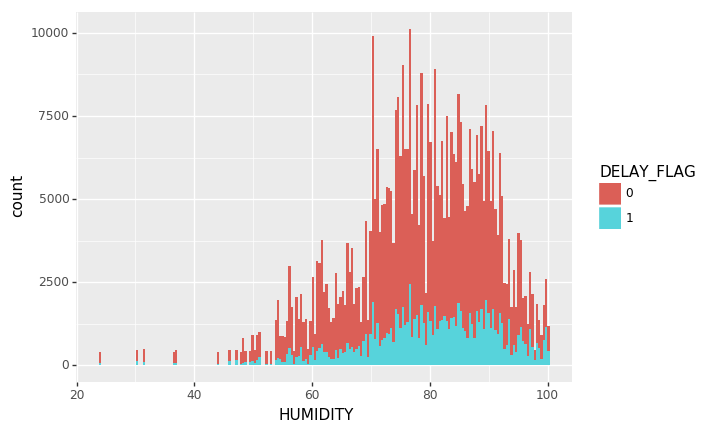

<ggplot: (-9223372036780869821)>

In [152]:
(p9.ggplot(full_df[['HUMIDITY','DELAY_FLAG']].dropna(axis=0)) 
 + p9.aes(x = 'HUMIDITY',fill = 'factor(DELAY_FLAG)') 
 + p9.geom_histogram()
 + p9.labs(fill='DELAY_FLAG')
)

- __The histogram shows left skewed distribution. Most flights concentrate in 70-95 interval.__

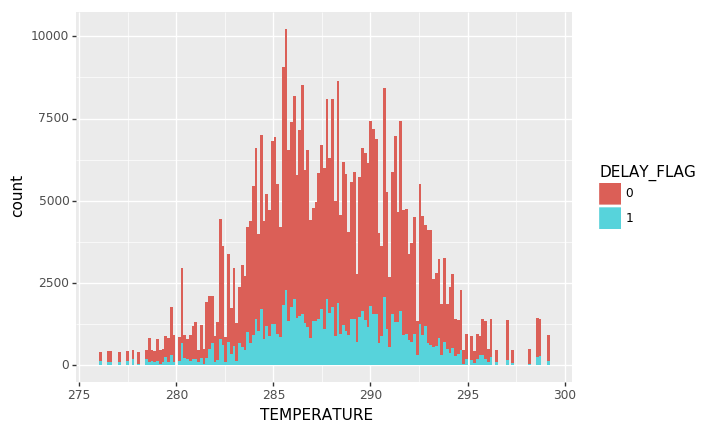

<ggplot: (78561365)>

In [153]:
(p9.ggplot(full_df[['TEMPERATURE','DELAY_FLAG']].dropna(axis=0)) 
 + p9.aes(x = 'TEMPERATURE',fill = 'factor(DELAY_FLAG)') 
 + p9.geom_histogram()
 + p9.labs(fill='DELAY_FLAG')
)

- __The histogram shows normal distribution. Most flights concentrate in 282.5-292.5 interval.__

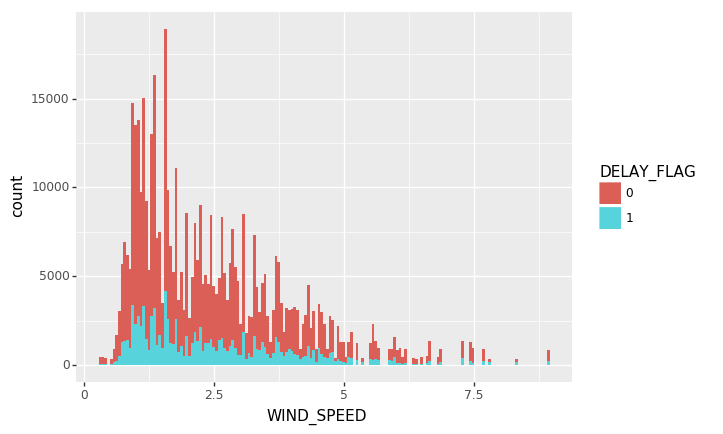

<ggplot: (-9223372036784695983)>

In [154]:
(p9.ggplot(full_df[['WIND_SPEED','DELAY_FLAG']].dropna(axis=0)) 
 + p9.aes(x = 'WIND_SPEED',fill = 'factor(DELAY_FLAG)') 
 + p9.geom_histogram()
 + p9.labs(fill='DELAY_FLAG')
)

- __The histogram shows right skewed distribution. Higher wind speed has less flights.__

# 3. Machine Learning Models

In [96]:
from sklearn import neighbors, preprocessing, impute, metrics, model_selection, linear_model, svm, feature_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [97]:
sfo = full_df[['DELAY_FLAG','WEATHER', 'YEAR','MONTH', 'OP_UNIQUE_CARRIER','DAY_OF_WEEK', 'DEST', 'DISTANCE', 'HOUR', 'HDAYS', 
               'HUMIDITY', 'TEMPERATURE', 'WIND_SPEED']]
sfo.head()

,DELAY_FLAG,WEATHER,YEAR,MONTH,OP_UNIQUE_CARRIER,DAY_OF_WEEK,DEST,DISTANCE,HOUR,HDAYS,HUMIDITY,TEMPERATURE,WIND_SPEED
0,0.0,1,2013,1,F9,2,DEN,967.0,6,0,61.136364,279.84875,1.666667
1,0.0,1,2013,1,F9,2,DEN,967.0,18,0,61.136364,279.84875,1.666667
2,0.0,1,2013,1,F9,2,DEN,967.0,10,0,61.136364,279.84875,1.666667
3,0.0,1,2013,1,F9,2,DEN,967.0,14,0,61.136364,279.84875,1.666667
4,1.0,1,2013,1,FL,2,ATL,2139.0,23,0,61.136364,279.84875,1.666667


In [98]:
OH_AIR = pd.get_dummies(sfo.OP_UNIQUE_CARRIER, prefix='OH') #on-hot encode airline 
OH_DEST = pd.get_dummies(sfo.DEST, prefix='OH') #on-hot encode destination
sfo = pd.concat([sfo, OH_AIR, OH_DEST], axis=1)
del sfo['OP_UNIQUE_CARRIER']
del sfo['DEST']

In [99]:
sfo['DAY_OF_WEEK'] = pd.Categorical(sfo.DAY_OF_WEEK)
sfo['YEAR'] = pd.Categorical(sfo.YEAR)
sfo['MONTH'] = pd.Categorical(sfo.MONTH)
sfo['HOUR'] = pd.Categorical(sfo.HOUR)
sfo['WEATHER'] = pd.Categorical(sfo.WEATHER, ordered = True)
sfo['DISTANCE'] = preprocessing.StandardScaler().fit_transform(sfo[['DISTANCE']]) #standardization
sfo['HUMIDITY'] = preprocessing.StandardScaler().fit_transform(sfo[['HUMIDITY']])
sfo['WIND_SPEED'] = preprocessing.StandardScaler().fit_transform(sfo[['WIND_SPEED']])
sfo['DELAY_FLAG'] = sfo.DELAY_FLAG.astype(int)

## 3.1 Sampling

### under sampling

In [100]:
non_delay = sfo.query('DELAY_FLAG==0').reset_index()
non_delay.insert(0,'dummy',0)# create a dummy label

In [101]:
X = non_delay.drop("dummy", axis=1)
y = non_delay['dummy']

In [102]:
#use StratifiedKFold as a stratified sampling tool
skf = model_selection.StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(X,y):
    sample1, sample2 = X.iloc[train_index], X.iloc[test_index]
    dummy_tr, dummy_te = y.iloc[train_index], y.iloc[test_index]

In [103]:
sample1.head()

,index,DELAY_FLAG,WEATHER,YEAR,MONTH,DAY_OF_WEEK,DISTANCE,HOUR,HDAYS,HUMIDITY,TEMPERATURE,WIND_SPEED,OH_AA,OH_AS,OH_B6,OH_DL,OH_F9,OH_FL,OH_HA,OH_OO,OH_UA,OH_US,OH_VX,OH_WN,OH_ABQ,OH_ACV,OH_ANC,OH_ASE,OH_ATL,OH_AUS,OH_BFL,OH_BOI,OH_BOS,OH_BUR,OH_BWI,OH_BZN,OH_CEC,OH_CIC,OH_CLE,OH_CLT,OH_COS,OH_CVG,OH_DAL,OH_DCA,OH_DEN,OH_DFW,OH_DTW,OH_EUG,OH_EWR,OH_FAT,OH_FLL,OH_GEG,OH_HDN,OH_HNL,OH_IAD,OH_IAH,OH_IND,OH_ITO,OH_JAC,OH_JFK,OH_KOA,OH_LAS,OH_LAX,OH_LGB,OH_LIH,OH_LMT,OH_MCI,OH_MCO,OH_MDW,OH_MFR,OH_MIA,OH_MKE,OH_MMH,OH_MOD,OH_MRY,OH_MSN,OH_MSO,OH_MSP,OH_MSY,OH_MTJ,OH_OGG,OH_OKC,OH_OMA,OH_ONT,OH_ORD,OH_OTH,OH_PDX,OH_PHL,OH_PHX,OH_PIT,OH_PSC,OH_PSP,OH_RDD,OH_RDM,OH_RDU,OH_RNO,OH_SAN,OH_SAT,OH_SBA,OH_SBP,OH_SEA,OH_SLC,OH_SMF,OH_SMX,OH_SNA,OH_STL,OH_SUN,OH_TUS,OH_XNA
0,0,0,1,2013,1,2,-0.227023,6,0,-1.521462,279.84875,-0.545369,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,2013,1,2,-0.227023,18,0,-1.521462,279.84875,-0.545369,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,1,2013,1,2,-0.227023,10,0,-1.521462,279.84875,-0.545369,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,2013,1,2,-0.227023,14,0,-1.521462,279.84875,-0.545369,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,2013,1,2,1.077076,13,0,-1.521462,279.84875,-0.545369,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
print(sample1.shape, sample2.shape)

(255826, 109) (127913, 109)


In [105]:
delay = sfo.query('DELAY_FLAG==1')
delay.shape

(103890, 108)

__Since we want to a relatively balanced sample, we choose smaller sample.__

In [106]:
sample2 = sample2.drop("index",axis=1)

In [107]:
under = pd.concat([sample2,delay],ignore_index=True)

## 3.1 Random Forest Model

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [109]:
#pick the features and lables
features = under.drop("DELAY_FLAG", axis=1)   #under[['HDAYS', 'HOUR', 'HUMIDITY', 'TEMPERATURE', 'WIND_SPEED']]
features_name = list(under)[1:]
label = under['DELAY_FLAG'] #extract label
X_tr, X_te, y_tr, y_te = train_test_split(features, label, test_size=0.2)

In [110]:
clf = RandomForestClassifier(n_estimators=100)  #create a Gaussian Classifier
clf.fit(X_tr, y_tr)
lable_pred = clf.predict(X_te)

In [111]:
pd.crosstab(y_te,lable_pred)

col_0,0,1
DELAY_FLAG,,
0,23584,1872
1,4554,16351


In [112]:
print("Accuracy:" ,metrics.accuracy_score(y_te, lable_pred))

Accuracy: 0.8613921183753586


In [113]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [114]:
#check feature important score
feature_imp = pd.Series(clf.feature_importances_,index=features_name).sort_values(ascending=False)
feature_imp[:10]

YEAR           0.400911
HOUR           0.147770
HUMIDITY       0.065282
TEMPERATURE    0.063176
WIND_SPEED     0.056660
MONTH          0.043618
HDAYS          0.036902
DISTANCE       0.032494
DAY_OF_WEEK    0.022833
WEATHER        0.012305
dtype: float64

No handles with labels found to put in legend.


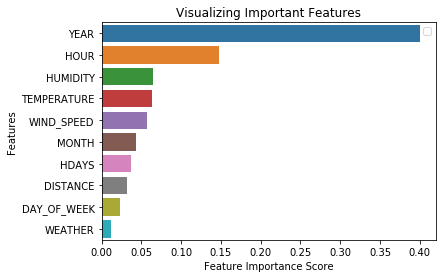

In [115]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [117]:
print(classification_report(y_te, lable_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     25456
           1       0.90      0.78      0.84     20905

   micro avg       0.86      0.86      0.86     46361
   macro avg       0.87      0.85      0.86     46361
weighted avg       0.86      0.86      0.86     46361



In [118]:
y_pred_pro_rf = clf.predict_proba(X_te) #calculate class probability of testing set
y_scores_rf = pd.DataFrame(y_pred_pro_rf, columns=clf.classes_.tolist())[1].values
auc_value_rf = roc_auc_score(y_te, y_scores_rf)
auc_value_rf

0.9145577538221378

## 3.2 K-NN Model

In [119]:
from sklearn.neighbors import KNeighborsClassifier
import time

In [120]:
#calculate sensitivity and specificity for each k choice
start = time.time()
k = range(1,20)
sensitivity = []
specificity = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr,y_tr)
    pred = knn.predict(X_te)
    tab = pd.crosstab(y_te,pred)
    sensitivity.append(tab.iloc[0,0]/tab.iloc[0,:].sum())
    specificity.append(tab.iloc[1,1]/tab.iloc[1,:].sum())
end = time.time()
running = end-start

In [121]:
eval_dict={'sensitivity':sensitivity,'specificity':specificity}
eval_tab = pd.DataFrame(eval_dict)
eval_tab.index = range(1,20)
eval_tab

,sensitivity,specificity
1,0.835402,0.799761
2,0.960245,0.738005
3,0.907055,0.787658
4,0.964173,0.749486
5,0.931961,0.778905
6,0.966059,0.750969
7,0.946692,0.773164
8,0.968848,0.750442
9,0.954745,0.768046
10,0.969870,0.750586


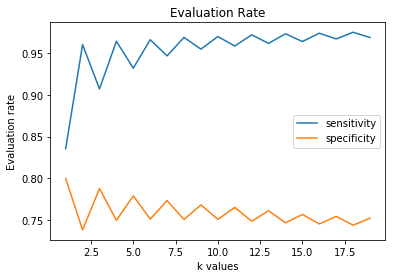

In [132]:
eval_tab.sensitivity.plot(label = 'sensitivity')
eval_tab.specificity.plot(label = 'specificity')
plt.xlabel('k values')
plt.ylabel('Evaluation rate')
plt.title('Evaluation Rate')
plt.legend()
plt.show()

In [124]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_tr,y_tr)
pre = knn.predict(X_te)

In [125]:
metrics.accuracy_score(y_te,pre)

0.870990703392938

In [129]:
pd.crosstab(y_te,pre)

col_0,0,1
DELAY_FLAG,,
0,24689,767
1,5214,15691


In [126]:
y_pred_pro_nn = knn.predict_proba(X_te)
y_scores_nn = pd.DataFrame(y_pred_pro_nn, columns=knn.classes_.tolist())[1].values
print(classification_report(y_te, pre))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     25456
           1       0.95      0.75      0.84     20905

   micro avg       0.87      0.87      0.87     46361
   macro avg       0.89      0.86      0.87     46361
weighted avg       0.88      0.87      0.87     46361



In [127]:
auc_value_nn = roc_auc_score(y_te, y_scores_nn)
auc_value_nn

0.911937704253371

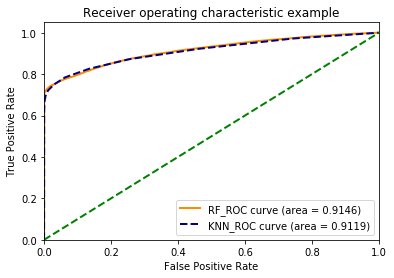

In [128]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_te, y_scores_rf, pos_label=1.0)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_te, y_scores_nn, pos_label=1.0)
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange', linewidth=lw, label='RF_ROC curve (area = %0.4f)' % auc_value_rf)
plt.plot(fpr_nn, tpr_nn, color='navy', linewidth=lw, linestyle='--', label='KNN_ROC curve (area = %0.4f)' % auc_value_nn)
plt.plot([0, 1], [0, 1], color='green', linewidth=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

- __To further compare two models, we also plot the ROC curve. From this figure, both of the models have good performance because they are in the upper left corner. And in terms of AUC, which is the area under the curve, Random Forest has a little bit better performance.__